For the following use the minute-resolution data set for the Stations DeepCove, and James Bay. The aim is to extract the variance associated with the diurnal signal, only. Consider i) data from 1 June to 30 September 2017), and ii) data from 1 November 2018 to 28 February 2019

1. Use a combination of an elliptic high-pass and an elliptic low-pass filter (i.e. using a high-pass and low-pass filter successively) to extract the diurnal frequency band. Show the frequency response of the filters, on the same plot.

2. For the two data sections of each station:

    a) Plot the raw and the filtered time series, on the same plot, using subplots for summer and winter data.
    
    b) In the time domain, calculate the variances of the full signal and the variances associated with the diurnal cycle.
    
    c) Plot the power spectral densities in a variance preserving form f x $\Gamma$(f) vs. log(f) with the frequency given in cycles per day. Plot spectra of the summer and winter data on the same plot. Generate plots for the unfiltered and for the filtered time series.
    
    d) In the frequency domain, estimate the variances of the diurnal cycle.

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
%matplotlib nbagg

In [4]:
from scipy import signal

In [5]:
import sys

In [6]:
from datetime import datetime, timedelta

In [7]:
import scipy.interpolate as sci

In [8]:
import pandas as pd

In [9]:
fs = 1/60 #Hz; Sampling frequency of minute resolution data
nyq = 0.5*fs #Hz; Nyquist frequency

In [10]:
epoch = datetime(1, 1, 1)

# Gathering and Filling the data

### Let's start with James Bay's Data

In [11]:
james_bay_min = np.loadtxt("Data/AllStations_temperature_minute_data_2019/JamesBay_temperature_2019.dat")

In [12]:
james_bay_min_time = np.linspace(james_bay_min[0], james_bay_min[1], int(james_bay_min[2]))
james_bay_min_temp = james_bay_min[3:]

In [13]:
min_res_jb_17_time = []
min_res_jb_17_time_float = []
min_res_jb_17_temp = []
nan_list_jb_17 = []

min_res_jb_18_time = []
min_res_jb_18_temp = []
min_res_jb_18_time_float = []
nan_list_jb_18 = []

for i in range(len(james_bay_min_time)):
    time = epoch + timedelta(days=james_bay_min_time[i] - 367.0 - 7.0/24) #Summer daylight saving time
    test1 = time.year == 2017 and time.month >= 6
    test2 = time.year == 2017 and time.month <= 9
    test3 = time.year == 2018 and time.month >= 11
    test4 = time.year == 2019 and time.month <= 2
    stop_when = time.year == 2019 and time.month == 3 and time.day == 1
    
    if test1 and test2:
        min_res_jb_17_time.append(time)
        min_res_jb_17_time_float.append(james_bay_min_time[i])
        min_res_jb_17_temp.append(james_bay_min_temp[i])
        
        if np.isnan(james_bay_min_temp[i]):
            #print(len(min_res_jb_17_temp) - 1)
            nan_list_jb_17.append(len(min_res_jb_17_temp) - 1)
    
    if test4 or test3:
        min_res_jb_18_time.append(epoch + timedelta(days=james_bay_min_time[i] - 367.0 - 8.0/24)) #Winter non-daylight-saving-time
        min_res_jb_18_time_float.append(james_bay_min_time[i])
        min_res_jb_18_temp.append(james_bay_min_temp[i])  
        
        if np.isnan(james_bay_min_temp[i]):
            #print(len(min_res_jb_18_temp) - 1)
            nan_list_jb_18.append(len(min_res_jb_18_temp) - 1)
            
    if stop_when:
        print("len(nan_list_jb_17) = ", len(nan_list_jb_17))
        print("len(nan_list_jb_18) = ", len(nan_list_jb_18))
        #print()
        print("Done")
        break

len(nan_list_jb_17) =  32
len(nan_list_jb_18) =  61
Done


In [14]:
min_res_jb_17_temp[nan_list_jb_17[-1]] #NaNs present in James Bay Summer data

nan

In [15]:
min_res_jb_18_temp[nan_list_jb_18[-1]] #NaNs present in James Bay Winter data

nan

### There seem to be a large number of NaNs in place of data. Lets plot it out and see what it looks like.

<IPython.core.display.Javascript object>


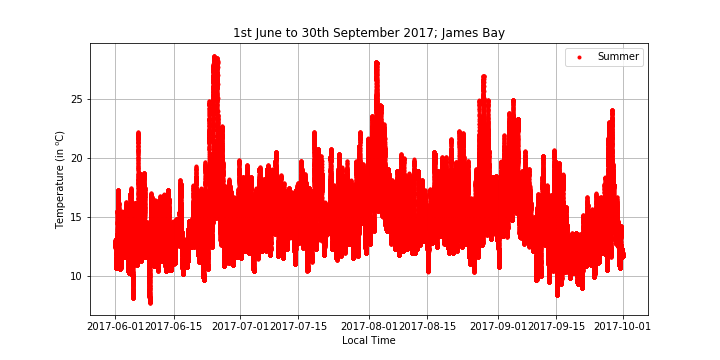

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [16]:
plt.close()
plt.figure(figsize=(10, 5))
plt.plot(min_res_jb_17_time, min_res_jb_17_temp, 'r.', label="Summer")
plt.title("1st June to 30th September 2017; James Bay")
plt.xlabel("Local Time")
plt.ylabel("Temperature (in \u2070C)")
plt.grid(True)
plt.legend()

In [17]:
plt.close()

<IPython.core.display.Javascript object>


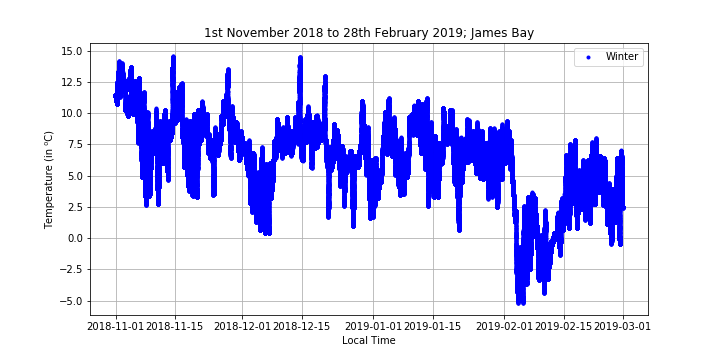

In [18]:
plt.close()
plt.figure(figsize=(10, 5))
plt.plot(min_res_jb_18_time, min_res_jb_18_temp, 'b.', label="Winter")
plt.title("1st November 2018 to 28th February 2019; James Bay")
plt.xlabel("Local Time")
plt.ylabel("Temperature (in \u2070C)")
plt.grid(True)
plt.legend()

In [19]:
plt.close()

### From the graphs, the NaN's in the data are not obvious -> Use of simple linear interpolation is enough to fill the data

In [20]:
filler_time_jb_17 = min_res_jb_17_time_float.copy()
filler_temp_jb_17 = min_res_jb_17_temp.copy()

for i in range(len(nan_list_jb_17)):
    filler_time_jb_17.pop(nan_list_jb_17[i] - i)
    filler_temp_jb_17.pop(nan_list_jb_17[i] - i)
    
filler_fn_jb_17 = sci.interp1d(filler_time_jb_17, filler_temp_jb_17)

for i in nan_list_jb_17:
    min_res_jb_17_temp[i] = filler_fn_jb_17(min_res_jb_17_time_float[i])

In [21]:
filler_time_jb_18 = min_res_jb_18_time_float.copy()
filler_temp_jb_18 = min_res_jb_18_temp.copy()

for i in range(len(nan_list_jb_18)):
    filler_time_jb_18.pop(nan_list_jb_18[i] - i)
    filler_temp_jb_18.pop(nan_list_jb_18[i] - i)
    
filler_fn_jb_18 = sci.interp1d(filler_time_jb_18, filler_temp_jb_18)

for i in nan_list_jb_18:
    min_res_jb_18_temp[i] = filler_fn_jb_18(min_res_jb_18_time_float[i])

### Now let us repeat the process for Deep Cove data

In [22]:
deep_cove_min = np.loadtxt("Data/AllStations_temperature_minute_data_2019/DeepCove_temperature_2019.dat")

In [23]:
deep_cove_min_time = np.linspace(deep_cove_min[0], deep_cove_min[1], int(deep_cove_min[2]))
deep_cove_min_temp = deep_cove_min[3:]

In [24]:
min_res_dc_17_time = []
min_res_dc_17_time_float = []
min_res_dc_17_temp = []
nan_list_dc_17 = []

min_res_dc_18_time = []
min_res_dc_18_temp = []
min_res_dc_18_time_float = []
nan_list_dc_18 = []

for i in range(len(deep_cove_min_time)):
    time = epoch + timedelta(days=deep_cove_min_time[i] - 367.0 - 7.0/24) #Summer daylight saving time
    test1 = time.year == 2017 and time.month >= 6
    test2 = time.year == 2017 and time.month <= 9
    test3 = time.year == 2018 and time.month >= 11
    test4 = time.year == 2019 and time.month <= 2
    stop_when = time.year == 2019 and time.month == 3 and time.day == 1
    
    if test1 and test2:
        min_res_dc_17_time.append(time)
        min_res_dc_17_time_float.append(deep_cove_min_time[i])
        min_res_dc_17_temp.append(deep_cove_min_temp[i])
        
        if np.isnan(deep_cove_min_temp[i]):
            #print(len(min_res_dc_17_temp) - 1)
            nan_list_dc_17.append(len(min_res_dc_17_temp) - 1)
    
    if test4 or test3:
        min_res_dc_18_time.append(epoch + timedelta(days=deep_cove_min_time[i] - 367.0 - 8.0/24)) #Winter non-daylight-saving-time
        min_res_dc_18_time_float.append(deep_cove_min_time[i])
        min_res_dc_18_temp.append(deep_cove_min_temp[i])  
        
        if np.isnan(deep_cove_min_temp[i]):
            #print(len(min_res_dc_18_temp) - 1)
            nan_list_dc_18.append(len(min_res_dc_18_temp) - 1)
            
    if stop_when:
        print("len(nan_list_dc_17) = ", len(nan_list_dc_17))
        print("len(nan_list_dc_18) = ", len(nan_list_dc_18))
        #print()
        print("Done")
        break

len(nan_list_dc_17) =  0
len(nan_list_dc_18) =  34134
Done


In [25]:
min_res_dc_18_temp[nan_list_dc_18[-1]] #NaNs present in Deep Winter data

nan

<IPython.core.display.Javascript object>


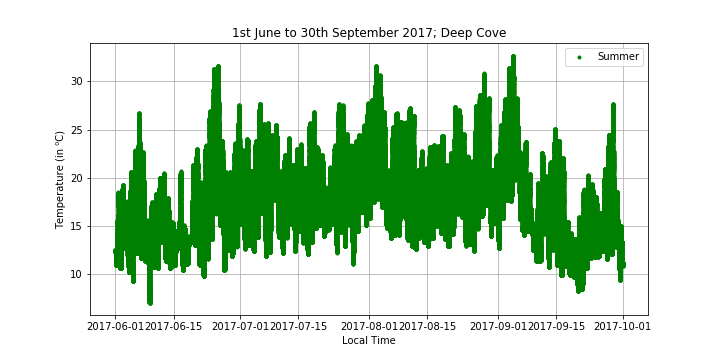

In [26]:
plt.close()
plt.figure(figsize=(10, 5))
plt.plot(min_res_dc_17_time, min_res_dc_17_temp, 'g.', label="Summer")
plt.title("1st June to 30th September 2017; Deep Cove")
plt.xlabel("Local Time")
plt.ylabel("Temperature (in \u2070C)")
plt.grid(True)
plt.legend()

In [27]:
plt.close()

<IPython.core.display.Javascript object>


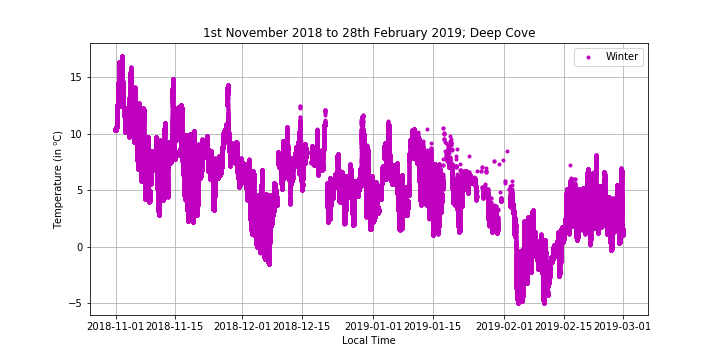

In [28]:
plt.close()
plt.figure(figsize=(10, 5))
plt.plot(min_res_dc_18_time, min_res_dc_18_temp, 'm.', label="Winter")
plt.title("1st November 2018 to 28th February 2019; Deep Cove")
plt.xlabel("Local Time")
plt.ylabel("Temperature (in \u2070C)")
plt.grid(True)
plt.legend()

In [29]:
plt.close()

### Deep Cove's Summer data is complete!

### Deep Cove Winter data does have visible gaps in the Late Jan. to Early Fab region... but they are not substantial. It does exhibit all the major peaks observed in the James Bay data for same time period (which was more complete). Linear Interpolation should work here as well.

In [30]:
filler_time_dc_18 = min_res_dc_18_time_float.copy()
filler_temp_dc_18 = min_res_dc_18_temp.copy()

for i in range(len(nan_list_dc_18)):
    filler_time_dc_18.pop(nan_list_dc_18[i] - i)
    filler_temp_dc_18.pop(nan_list_dc_18[i] - i)
    
filler_fn_dc_18 = sci.interp1d(filler_time_dc_18, filler_temp_dc_18)

for i in nan_list_dc_18:
    min_res_dc_18_temp[i] = filler_fn_dc_18(min_res_dc_18_time_float[i])

Plotting filled data:

<IPython.core.display.Javascript object>


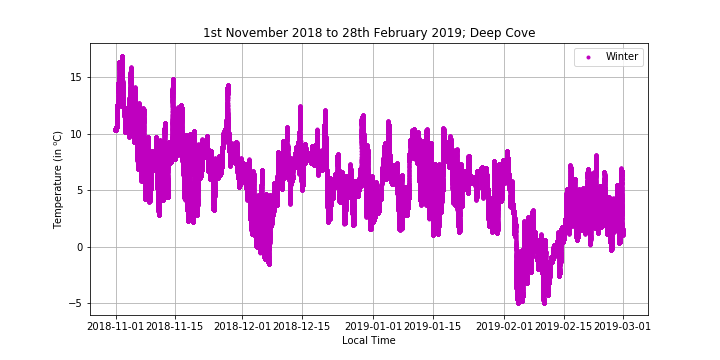

In [31]:
plt.close()
plt.figure(figsize=(10, 5))
plt.plot(min_res_dc_18_time, min_res_dc_18_temp, 'm.', label="Winter")
plt.title("1st November 2018 to 28th February 2019; Deep Cove")
plt.xlabel("Local Time")
plt.ylabel("Temperature (in \u2070C)")
plt.grid(True)
plt.legend()

In [32]:
plt.close()

### No obvious peaks/edges. We're good to go!

# Question 1.1 - Filtering data

In [33]:
f_jb_17, PSD_jb_17 = signal.welch(min_res_jb_17_temp, fs, 'flattop', len(min_res_jb_17_temp), scaling='spectrum')

In [34]:
f_jb_18, PSD_jb_18 = signal.welch(min_res_jb_18_temp, fs, 'flattop', len(min_res_jb_18_temp), scaling='spectrum')

In [35]:
f_dc_17, PSD_dc_17 = signal.welch(min_res_dc_17_temp, fs, 'flattop', len(min_res_dc_17_temp), scaling='spectrum')

In [36]:
f_dc_18, PSD_dc_18 = signal.welch(min_res_dc_18_temp, fs, 'flattop', len(min_res_dc_18_temp), scaling='spectrum')

<IPython.core.display.Javascript object>


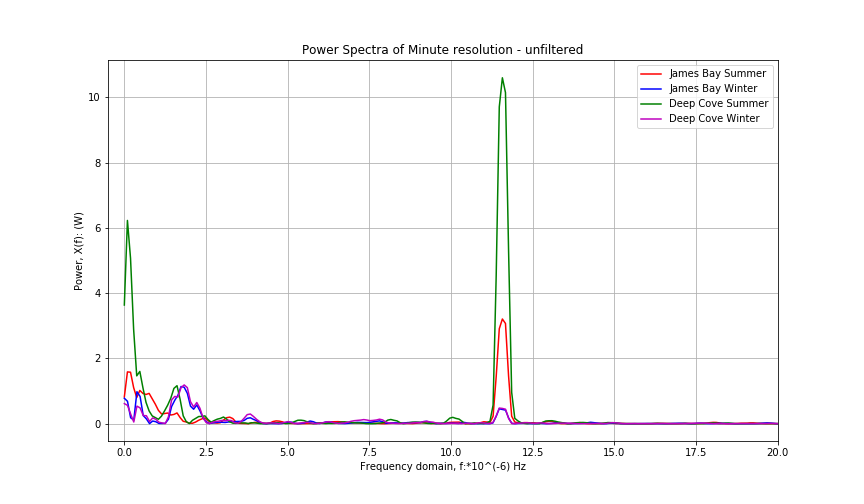

In [37]:
plt.close()

plt.figure(figsize=(12, 7))
plt.plot(f_jb_17*1e6, PSD_jb_17, 'r-', label="James Bay Summer")
plt.plot(f_jb_18*1e6, PSD_jb_18, 'b-', label="James Bay Winter")
plt.plot(f_dc_17*1e6, PSD_dc_17, 'g-', label="Deep Cove Summer")
plt.plot(f_dc_18*1e6, PSD_dc_18, 'm-', label="Deep Cove Winter")
plt.title("Power Spectra of Minute resolution - unfiltered")
plt.grid(True)
plt.xlabel("Frequency domain, f:*10^(-6) Hz")
plt.xlim(-0.5, 20)
plt.ylabel("Power, X(f): (W)")
plt.legend()

In [38]:
plt.close()

### All graphs exhibit diurnal cycle (Peak at ~11.6Hz). But Summer data shows it most clearly. And Deep Cove's Summer data exhibits it most clearly.

In [39]:
print(len(f_jb_17),len(f_jb_18),len(f_dc_17),len(f_dc_18)) #-> Therefore, will make 2 filters: 1 for Summer and one for Winter.

87841 86401 87841 86401


### First lets make Summer filter

In [40]:
order=1

In [41]:
#Designing bandpass digital filter such that frequencies above 15 microHz, and below 9 microHz (normalized by Nyquist freq.) 
#are cut-off
b, a = signal.ellip(N=order, rp=30, rs=20, Wn=[9*1e-6/nyq, 15*1e-6/nyq], btype='bandpass') #SciPy's Elliptical filter.

#rp = The maximum ripple allowed below unity gain in the passband. Specified in decibels, as a positive number 
#i.e. (how "peaky" the filter is)
#rs = The minimum attenuation required in the stop band. Specified in decibels, as a positive number.
#i.e. (how blocked should the blocked parts be)
#Outputs numerator and denominator coefficients, b, a resp., that are required for the above filter

#Using b, a and number of H points to be calculated (we need this equal to number of PSD points, for multiplication), 
#returns w and H(w)
w_17, h_17 = signal.freqz(b, a, worN=len(f_jb_17))

In [42]:
b_1, a_1 = signal.ellip(N=order, rp=5, rs=20, Wn=[9*1e-6/nyq, 15*1e-6/nyq], btype='bandpass')
b_2, a_2 = signal.ellip(N=order, rp=10, rs=20, Wn=[9*1e-6/nyq, 15*1e-6/nyq], btype='bandpass')
b_3, a_3 = signal.ellip(N=order, rp=20, rs=20, Wn=[9*1e-6/nyq, 15*1e-6/nyq], btype='bandpass')

w_1, h_1 = signal.freqz(b_1, a_1, worN=len(f_jb_17))
w_2, h_2 = signal.freqz(b_2, a_2, worN=len(f_jb_17))
w_3, h_3 = signal.freqz(b_3, a_3, worN=len(f_jb_17))

<IPython.core.display.Javascript object>


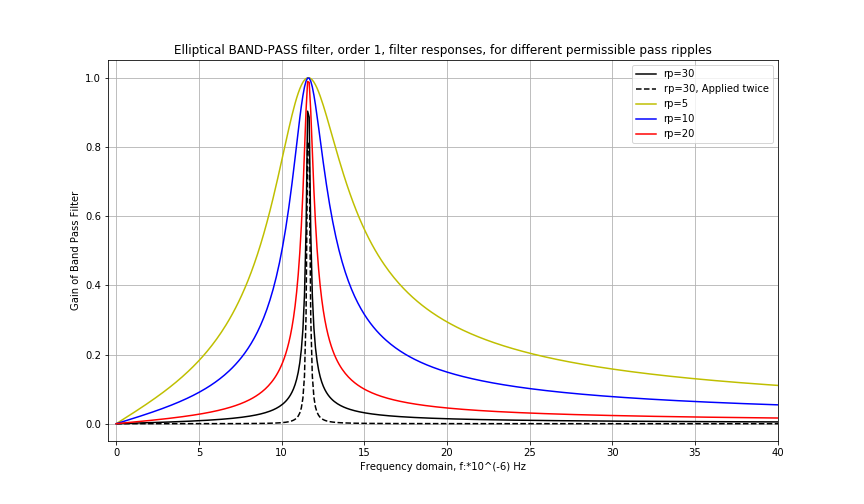

BANDPASS = High-pass + Low-Pass


In [43]:
plt.close()

plt.figure(figsize=(12, 7))
plt.plot(w_17*nyq*1e6/np.pi, abs(h_17), 'k-', label='rp=30')
plt.plot(w_17*nyq*1e6/np.pi, abs(h_17)*abs(h_17), 'k--', label='rp=30, Applied twice')
plt.plot(w_1*nyq*1e6/np.pi, abs(h_1), 'y-', label='rp=5')
plt.plot(w_2*nyq*1e6/np.pi, abs(h_2), 'b-', label='rp=10')
plt.plot(w_3*nyq*1e6/np.pi, abs(h_3), 'r-', label='rp=20')
plt.legend()
plt.title("Elliptical BAND-PASS filter, order " + str(order) + ", filter responses, for different permissible pass ripples")
plt.grid(True)
plt.ylabel("Gain of Band Pass Filter")
plt.xlabel("Frequency domain, f:*10^(-6) Hz")
plt.xlim(-0.5, 40)
print("BANDPASS = High-pass + Low-Pass")

In [44]:
plt.close()

### Am going to use rp=20 filter i.e. black line.

In [45]:
PSD_jb_17_filtered = PSD_jb_17*abs(h_17)
PSD_dc_17_filtered = PSD_dc_17*abs(h_17)

<IPython.core.display.Javascript object>


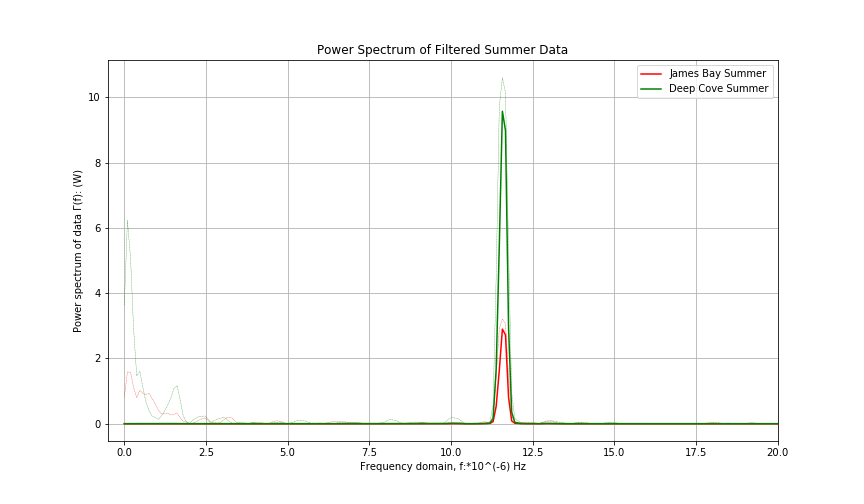

In [46]:
plt.close()

plt.figure(figsize=(12, 7))
plt.plot(f_jb_17*1e6, PSD_jb_17, 'r--', linewidth=0.3)
plt.plot(f_dc_17*1e6, PSD_dc_17, 'g--', linewidth=0.3)
plt.plot(f_jb_17*1e6, PSD_jb_17_filtered, 'r-', label="James Bay Summer")
plt.plot(f_dc_17*1e6, PSD_dc_17_filtered, 'g-', label="Deep Cove Summer")
plt.title("Power Spectrum of Filtered Summer Data")
plt.grid(True)
plt.xlabel("Frequency domain, f:*10^(-6) Hz")
plt.xlim(-0.5, 20)
plt.ylabel("Power spectrum of data \u0393(f): (W)")
plt.legend()

In [47]:
plt.close()

In [48]:
filtered_temp_jb_17 = signal.filtfilt(b, a, min_res_jb_17_temp)
filtered_temp_dc_17 = signal.filtfilt(b, a, min_res_dc_17_temp)

<IPython.core.display.Javascript object>


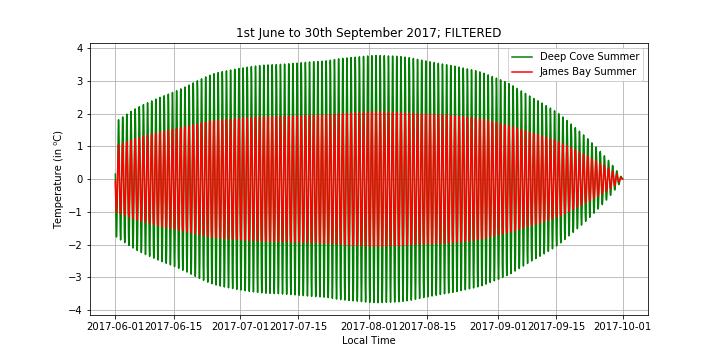

<IPython.core.display.Javascript object>


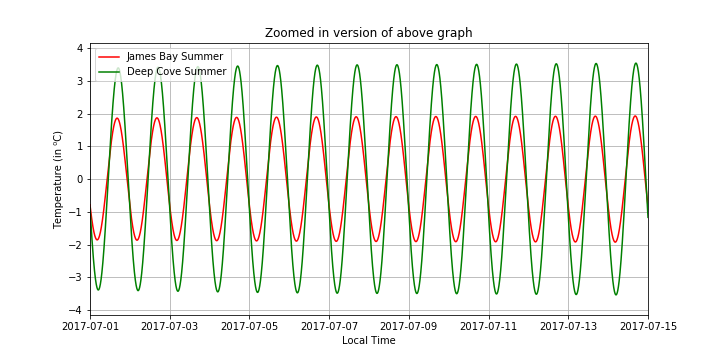

In [49]:
plt.close()
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(min_res_jb_17_time, filtered_temp_dc_17, 'g-', label="Deep Cove Summer")
plt.plot(min_res_jb_17_time, filtered_temp_jb_17, 'r-', label="James Bay Summer")
plt.title("1st June to 30th September 2017; FILTERED")
plt.xlabel("Local Time")
plt.ylabel("Temperature (in \u2070C)")
plt.grid(True)
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(min_res_jb_17_time, filtered_temp_jb_17, 'r-', label="James Bay Summer")
plt.plot(min_res_jb_17_time, filtered_temp_dc_17, 'g-', label="Deep Cove Summer")
plt.title("Zoomed in version of above graph")
plt.xlabel("Local Time")
plt.ylabel("Temperature (in \u2070C)")
plt.grid(True)
plt.xlim(datetime(2017, 7, 1), datetime(2017, 7, 15))
plt.legend()

In [50]:
plt.close()
plt.close()

### Now we do the same thing for the Winter data

In [51]:
b_18, a_18 = signal.ellip(N=order, rp=40, rs=50, Wn=[9*1e-6/nyq, 15*1e-6/nyq], btype='bandpass')
w_18, h_18 = signal.freqz(b_18, a_18, worN=len(f_jb_18))

<IPython.core.display.Javascript object>


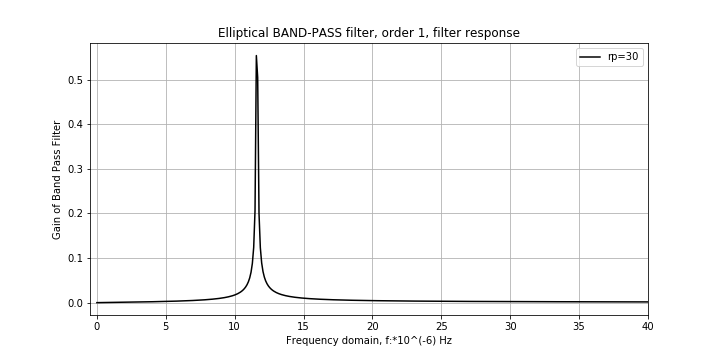

BANDPASS = High-pass + Low-Pass


In [52]:
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(w_18*nyq*1e6/np.pi, abs(h_18), 'k-', label='rp=30')
plt.legend()
plt.title("Elliptical BAND-PASS filter, order " + str(order) + ", filter response")
plt.grid(True)
plt.ylabel("Gain of Band Pass Filter")
plt.xlabel("Frequency domain, f:*10^(-6) Hz")
plt.xlim(-0.5, 40)
print("BANDPASS = High-pass + Low-Pass")

In [53]:
plt.close()

In [54]:
PSD_jb_18_filtered = PSD_jb_18*abs(h_18)
PSD_dc_18_filtered = PSD_dc_18*abs(h_18)

<IPython.core.display.Javascript object>


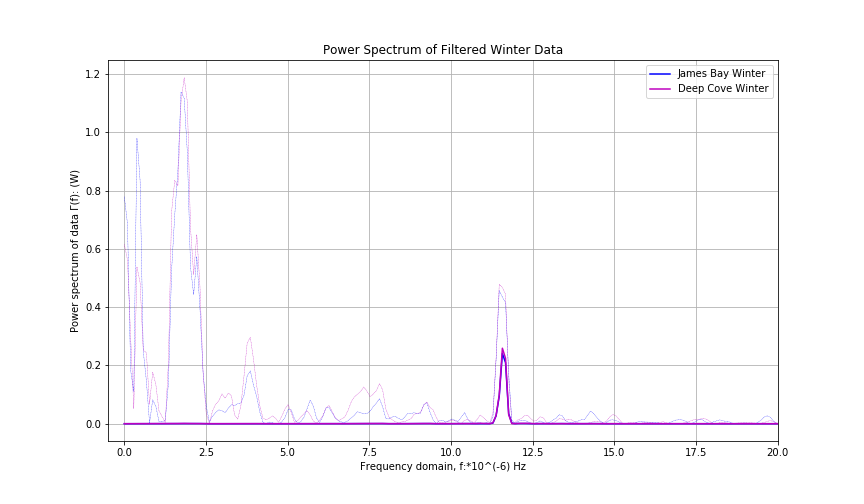

In [55]:
plt.close()

plt.figure(figsize=(12, 7))
plt.plot(f_jb_18*1e6, PSD_jb_18, 'b--', linewidth=0.3)
plt.plot(f_dc_18*1e6, PSD_dc_18, 'm--', linewidth=0.3)
plt.plot(f_jb_18*1e6, PSD_jb_18_filtered, 'b-', label="James Bay Winter")
plt.plot(f_dc_18*1e6, PSD_dc_18_filtered, 'm-', label="Deep Cove Winter")
plt.title("Power Spectrum of Filtered Winter Data")
plt.grid(True)
plt.xlabel("Frequency domain, f:*10^(-6) Hz")
plt.xlim(-0.5, 20)
plt.ylabel("Power spectrum of data \u0393(f): (W)")
plt.legend()

In [56]:
plt.close()

In [57]:
filtered_temp_jb_18 = signal.filtfilt(b_18, a_18, min_res_jb_18_temp)
filtered_temp_dc_18 = signal.filtfilt(b_18, a_18, min_res_dc_18_temp)

<IPython.core.display.Javascript object>


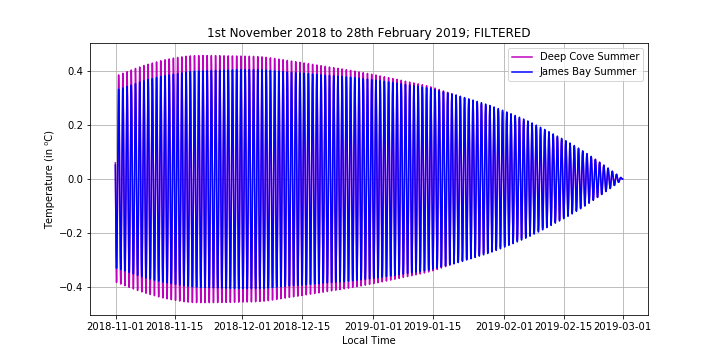

<IPython.core.display.Javascript object>


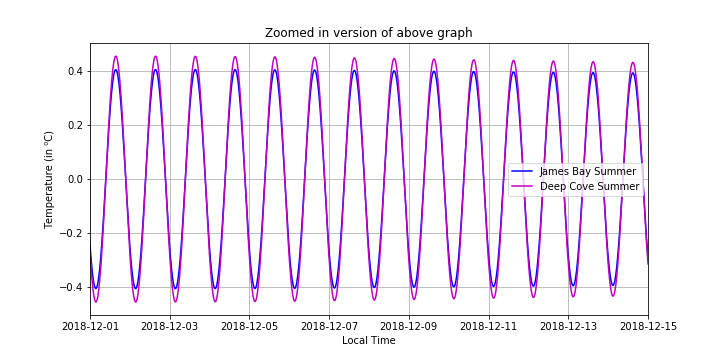

In [58]:
plt.close()
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(min_res_jb_18_time, filtered_temp_dc_18, 'm-', label="Deep Cove Summer")
plt.plot(min_res_jb_18_time, filtered_temp_jb_18, 'b-', label="James Bay Summer")
plt.title("1st November 2018 to 28th February 2019; FILTERED")
plt.xlabel("Local Time")
plt.ylabel("Temperature (in \u2070C)")
plt.grid(True)
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(min_res_jb_18_time, filtered_temp_jb_18, 'b-', label="James Bay Summer")
plt.plot(min_res_dc_18_time, filtered_temp_dc_18, 'm-', label="Deep Cove Summer")
plt.title("Zoomed in version of above graph")
plt.xlabel("Local Time")
plt.ylabel("Temperature (in \u2070C)")
plt.grid(True)
plt.xlim(datetime(2018, 12, 1), datetime(2018, 12, 15))
plt.legend()

In [59]:
plt.close()
plt.close()

### In both cases, I have chosen a very strict filter such that next-to-no-noise is allowed -> ONLY the diurnal signal is extracted. But by doing so, I have lost some of the energy stored in the diurnal signal. Inevitable trade-off.

# Question 1.2

In [60]:
dict_raw_jb_17 = {'Time': min_res_jb_17_time, 'Temperature': min_res_jb_17_temp}
dict_filtered_jb_17 = {'Time': min_res_jb_17_time, 'Temperature': filtered_temp_jb_17}
dict_raw_jb_18 = {'Time': min_res_jb_18_time, 'Temperature': min_res_jb_18_temp}
dict_filtered_jb_18 = {'Time': min_res_jb_18_time, 'Temperature': filtered_temp_jb_18}
dict_raw_dc_17 = {'Time': min_res_dc_17_time, 'Temperature': min_res_dc_17_temp}
dict_filtered_dc_17 = {'Time': min_res_dc_17_time, 'Temperature': filtered_temp_dc_17}
dict_raw_dc_18 = {'Time': min_res_dc_18_time, 'Temperature': min_res_dc_18_temp}
dict_filtered_dc_18 = {'Time': min_res_dc_18_time, 'Temperature': filtered_temp_dc_18}

In [61]:
raw_jb_17 = pd.DataFrame(dict_raw_jb_17)
raw_jb_18 = pd.DataFrame(dict_raw_jb_18)
filtered_jb_17 = pd.DataFrame(dict_filtered_jb_17)
filtered_jb_18 = pd.DataFrame(dict_filtered_jb_18)
raw_dc_17 = pd.DataFrame(dict_raw_dc_17)
raw_dc_18 = pd.DataFrame(dict_raw_dc_18)
filtered_dc_17 = pd.DataFrame(dict_filtered_dc_17)
filtered_dc_18 = pd.DataFrame(dict_filtered_dc_18)

In [62]:
mean_jb_17 = raw_jb_17["Temperature"].mean()
mean_jb_18 = raw_jb_18["Temperature"].mean()
mean_dc_17 = raw_dc_17["Temperature"].mean()
mean_dc_18 = raw_dc_18["Temperature"].mean()

<IPython.core.display.Javascript object>


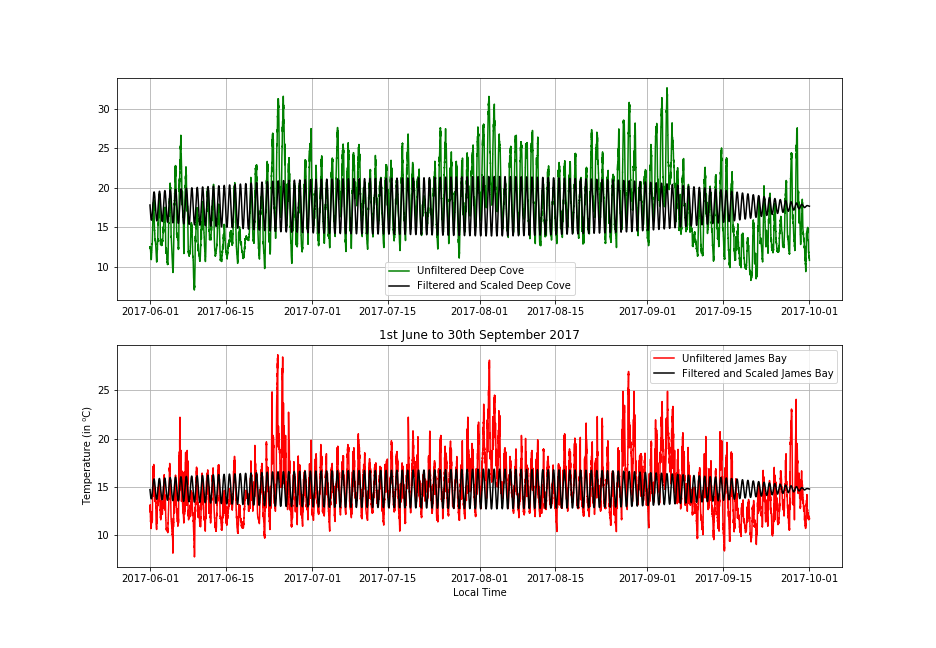

<IPython.core.display.Javascript object>


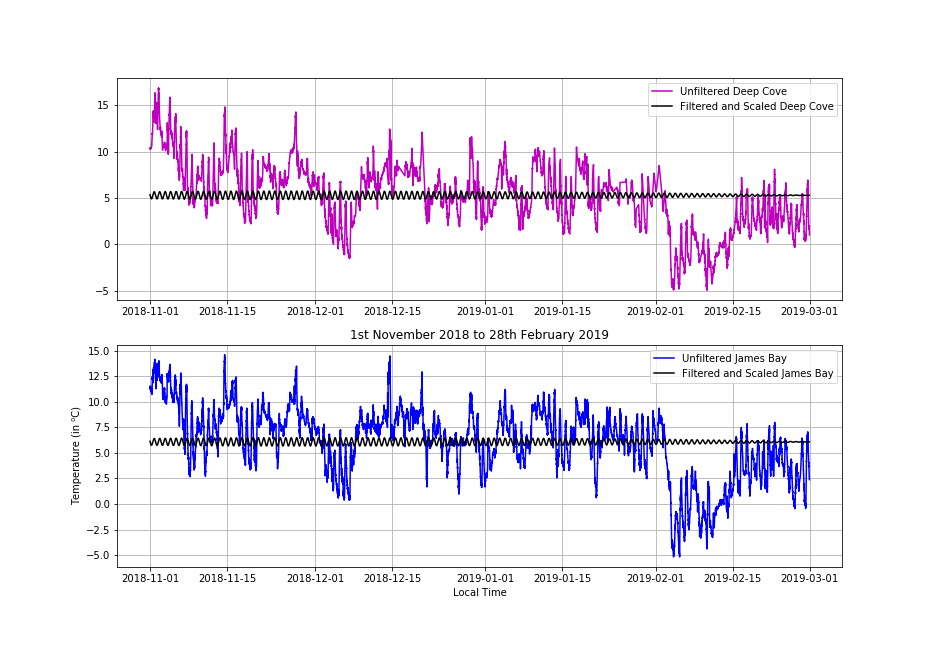

Text(0, 0.5, 'Temperature (in ⁰C)')

In [63]:
plt.close()
plt.close()

fig1, ax = plt.subplots(2, 1, figsize=(13, 9))
ax[0].plot(min_res_dc_17_time, min_res_dc_17_temp, 'g-', label="Unfiltered Deep Cove")
ax[0].plot(min_res_dc_17_time, filtered_temp_dc_17 + mean_dc_17, 'k-', label="Filtered and Scaled Deep Cove")
plt.title("1st June to 30th September 2017")
ax[0].grid(True)
ax[0].legend()

ax[1].plot(min_res_jb_17_time, min_res_jb_17_temp, 'r-', label="Unfiltered James Bay")
ax[1].plot(min_res_jb_17_time, filtered_temp_jb_17 + mean_jb_17, 'k-', label="Filtered and Scaled James Bay")
plt.xlabel("Local Time")
plt.ylabel("Temperature (in \u2070C)")
ax[1].grid(True)
ax[1].legend()

fig2, ax = plt.subplots(2, 1, figsize=(13, 9))

ax[0].plot(min_res_dc_18_time, min_res_dc_18_temp, 'm-', label="Unfiltered Deep Cove")
ax[0].plot(min_res_dc_18_time, filtered_temp_dc_18 + mean_dc_18, 'k-', label="Filtered and Scaled Deep Cove")
plt.title("1st November 2018 to 28th February 2019")
ax[0].grid(True)
ax[0].legend()

ax[1].plot(min_res_jb_18_time, min_res_jb_18_temp, 'b-', label="Unfiltered James Bay")
ax[1].plot(min_res_jb_18_time, filtered_temp_jb_18 + mean_jb_18, 'k-', label="Filtered and Scaled James Bay")
ax[1].grid(True)
ax[1].legend()
plt.xlabel("Local Time")
plt.ylabel("Temperature (in \u2070C)")

In [64]:
plt.close()
plt.close()

In [65]:
var_jb_17 = (raw_jb_17["Temperature"].std())**2
var_jb_18 = (raw_jb_18["Temperature"].std())**2
var_dc_17 = (raw_dc_17["Temperature"].std())**2
var_dc_18 = (raw_dc_18["Temperature"].std())**2

In [71]:
print("In the Time Domain: ")
print("Variance of James Bay - Summer: ", round(var_jb_17, 2))
print("Variance of Deep Cove - Summer: ", round(var_dc_17, 2))
print("Variance of James Bay - Winter: ", round(var_jb_18, 2))
print("Variance of Deep Cove - Winter: ", round(var_dc_18, 2))

In the Time Domain: 
Variance of James Bay - Summer:  7.74
Variance of Deep Cove - Summer:  19.83
Variance of James Bay - Winter:  11.41
Variance of Deep Cove - Winter:  12.42


<IPython.core.display.Javascript object>


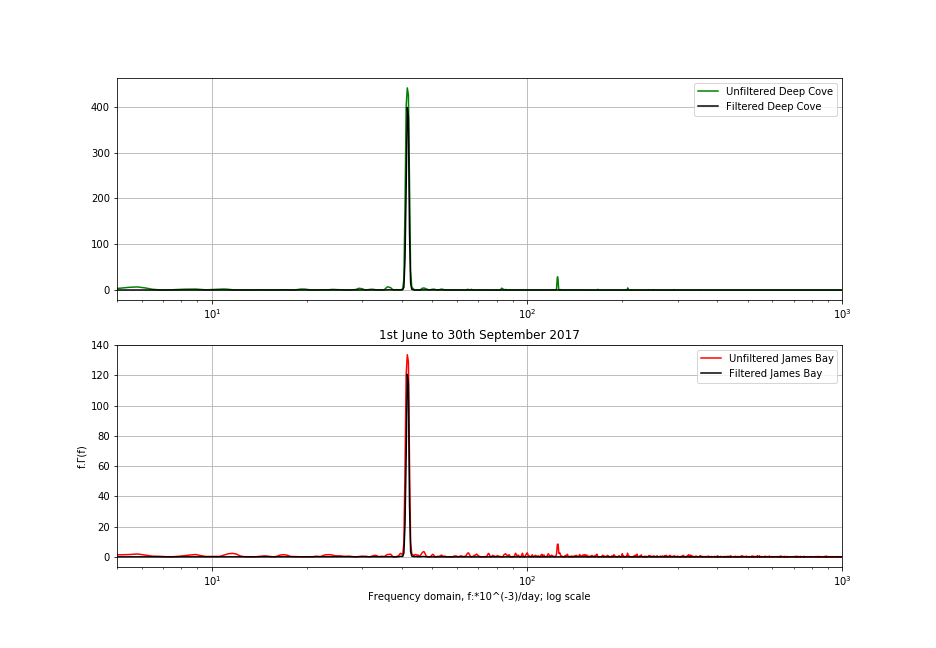

<IPython.core.display.Javascript object>


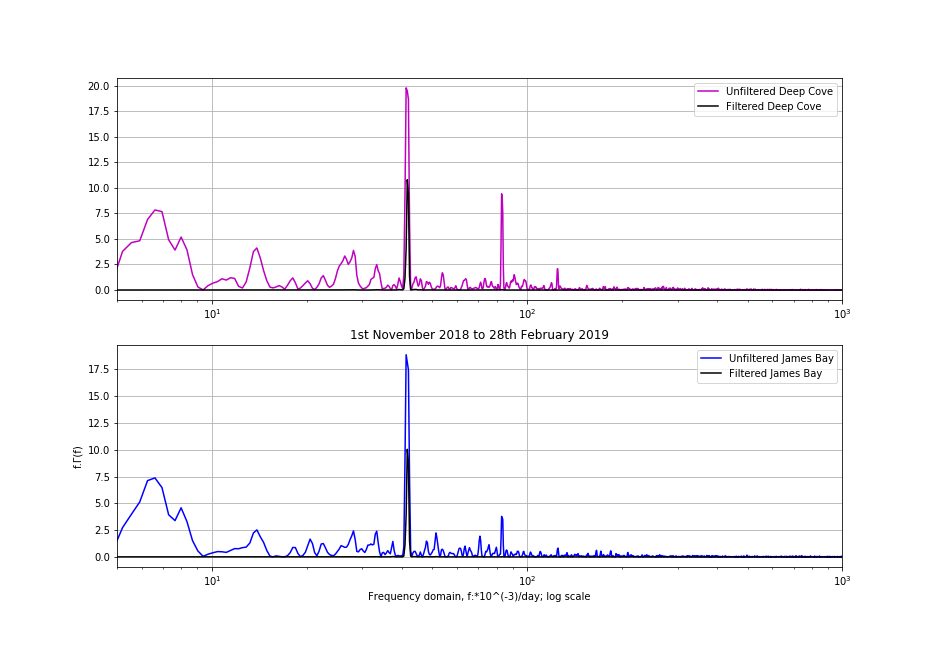

(5, 1000.0)

In [68]:
plt.close()
plt.close()

fig3, ax = plt.subplots(2, 1, figsize=(13, 9))
ax[0].semilogx(f_dc_17*3.6*1e6, f_dc_17*3.6*1e6*PSD_dc_17, 'g-', label="Unfiltered Deep Cove")
ax[0].semilogx(f_dc_17*3.6*1e6, f_dc_17*3.6*1e6*PSD_dc_17_filtered, 'k-', label="Filtered Deep Cove")
plt.title("1st June to 30th September 2017")
ax[0].set_xlim(5, 1e3)
ax[0].grid(True)
ax[0].legend()

ax[1].semilogx(f_jb_17*3.6*1e6, f_jb_17*3.6*1e6*PSD_jb_17, 'r-', label="Unfiltered James Bay")
ax[1].semilogx(f_jb_17*3.6*1e6, f_jb_17*3.6*1e6*PSD_jb_17_filtered, 'k-', label="Filtered James Bay")
plt.xlabel("Frequency domain, f:*10^(-3)/day; log scale")
plt.ylabel("f.\u0393(f)")
ax[1].set_xlim(5, 1e3)
ax[1].grid(True)
ax[1].legend()

fig4, ax = plt.subplots(2, 1, figsize=(13, 9))

ax[0].semilogx(f_dc_18*3.6*1e6, f_dc_18*3.6*1e6*PSD_dc_18, 'm-', label="Unfiltered Deep Cove")
ax[0].semilogx(f_dc_18*3.6*1e6, f_dc_18*3.6*1e6*PSD_dc_18_filtered, 'k-', label="Filtered Deep Cove")
plt.title("1st November 2018 to 28th February 2019")
ax[0].set_xlim(5, 1e3)
ax[0].grid(True)
ax[0].legend()

ax[1].semilogx(f_jb_18*3.6*1e6, f_jb_18*3.6*1e6*PSD_jb_18, 'b-', label="Unfiltered James Bay")
ax[1].semilogx(f_jb_18*3.6*1e6, f_jb_18*3.6*1e6*PSD_jb_18_filtered, 'k-', label="Filtered James Bay")
ax[1].grid(True)
ax[1].legend()
plt.xlabel("Frequency domain, f:*10^(-3)/day; log scale")
plt.ylabel("f.\u0393(f)")
ax[1].set_xlim(5, 1e3)

In [69]:
plt.close()
plt.close()

In [142]:
dict_freq_raw_jb_17 = {'f': f_jb_17, 'PSD': PSD_jb_17}
dict_freq_filtered_jb_17 = {'f': f_jb_17, 'PSD': PSD_jb_17_filtered}
dict_freq_raw_jb_18 = {'f': f_jb_18, 'PSD': PSD_jb_18}
dict_freq_filtered_jb_18 = {'f': f_jb_18, 'PSD': PSD_jb_18_filtered}
dict_freq_raw_dc_17 = {'f': f_dc_17, 'PSD': PSD_dc_17}
dict_freq_filtered_dc_17 = {'f': f_dc_17, 'PSD': PSD_dc_17_filtered}
dict_freq_raw_dc_18 = {'f': f_dc_18, 'PSD': PSD_dc_18}
dict_freq_filtered_dc_18 = {'f': f_dc_18, 'PSD': PSD_dc_18_filtered}

In [72]:
def function_integrator(fn, x_values):
    '''
    Takes function array (i.e. array of "y values"), 
    and integrates it from a to b; a, b > 0 (rectangluar integration)
    '''
    n = len(fn)
    area = 0
    for i in range(1, n):
        area += (x_values[i] - x_values[i - 1])*(fn[i] + fn[i - 1])/2
    return area

In [95]:
freq_var_jb_17 = function_integrator(3.6*1e6*PSD_jb_17, f_jb_17)
freq_var_jb_18 = function_integrator(3.6*1e6*PSD_jb_18, f_jb_18)
freq_var_dc_17 = function_integrator(3.6*1e6*PSD_dc_17, f_dc_17)
freq_var_dc_18 = function_integrator(3.6*1e6*PSD_dc_18, f_dc_18)

In [96]:
print("In the Frequency Domain: ")
print("Variance of James Bay - Summer: ", round(freq_var_jb_17, 2))
print("Variance of Deep Cove - Summer: ", round(freq_var_dc_17, 2))
print("Variance of James Bay - Winter: ", round(freq_var_jb_18, 2))
print("Variance of Deep Cove - Winter: ", round(freq_var_dc_18, 2))

In the Frequency Domain: 
Variance of James Bay - Summer:  11.38
Variance of Deep Cove - Summer:  26.38
Variance of James Bay - Winter:  6.14
Variance of Deep Cove - Winter:  6.92
